In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import os
import pc
import ecg_plot

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import optimize
from scipy.io import loadmat
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional

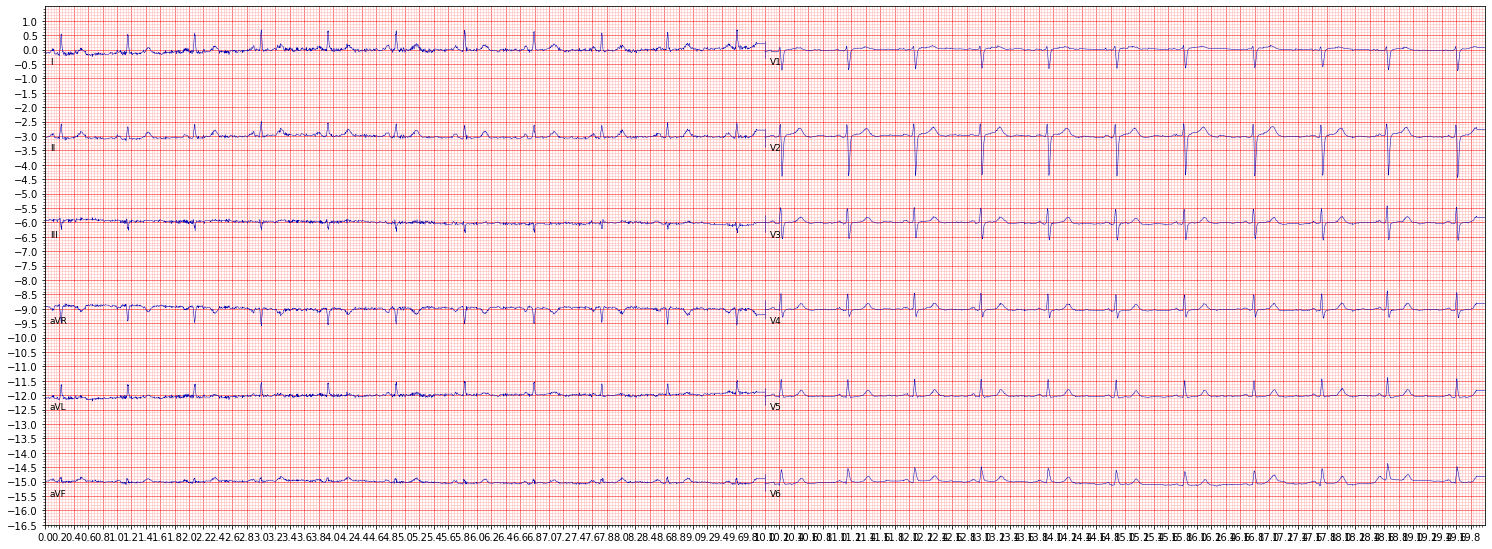

In [3]:
def plot_ecg(path):
    ecg_data = pc.load_challenge_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='')
    ecg_plot.show()
    
plot_ecg("WFDB/HR00001.mat")

In [4]:
gender, age, labels, ecg_filenames = pc.import_key_data("WFDB/")

In [5]:
ecg_filenames = np.asarray(ecg_filenames)

In [6]:
SNOMED_scored = pd.read_csv("SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored = pd.read_csv("SNOMED_mappings_unscored.csv", sep=";")
df_labels = pc.make_undefined_class(labels,SNOMED_unscored)

In [7]:
y , snomed_classes = pc.onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '251146004' '270492004' '284470004' '39732003'
 '426177001' '426783006' '427084000' '427393009' '445118002' '47665007'
 '59931005' '63593006' '698252002' '713426002' '713427006'
 'undefined class']
classes: 23


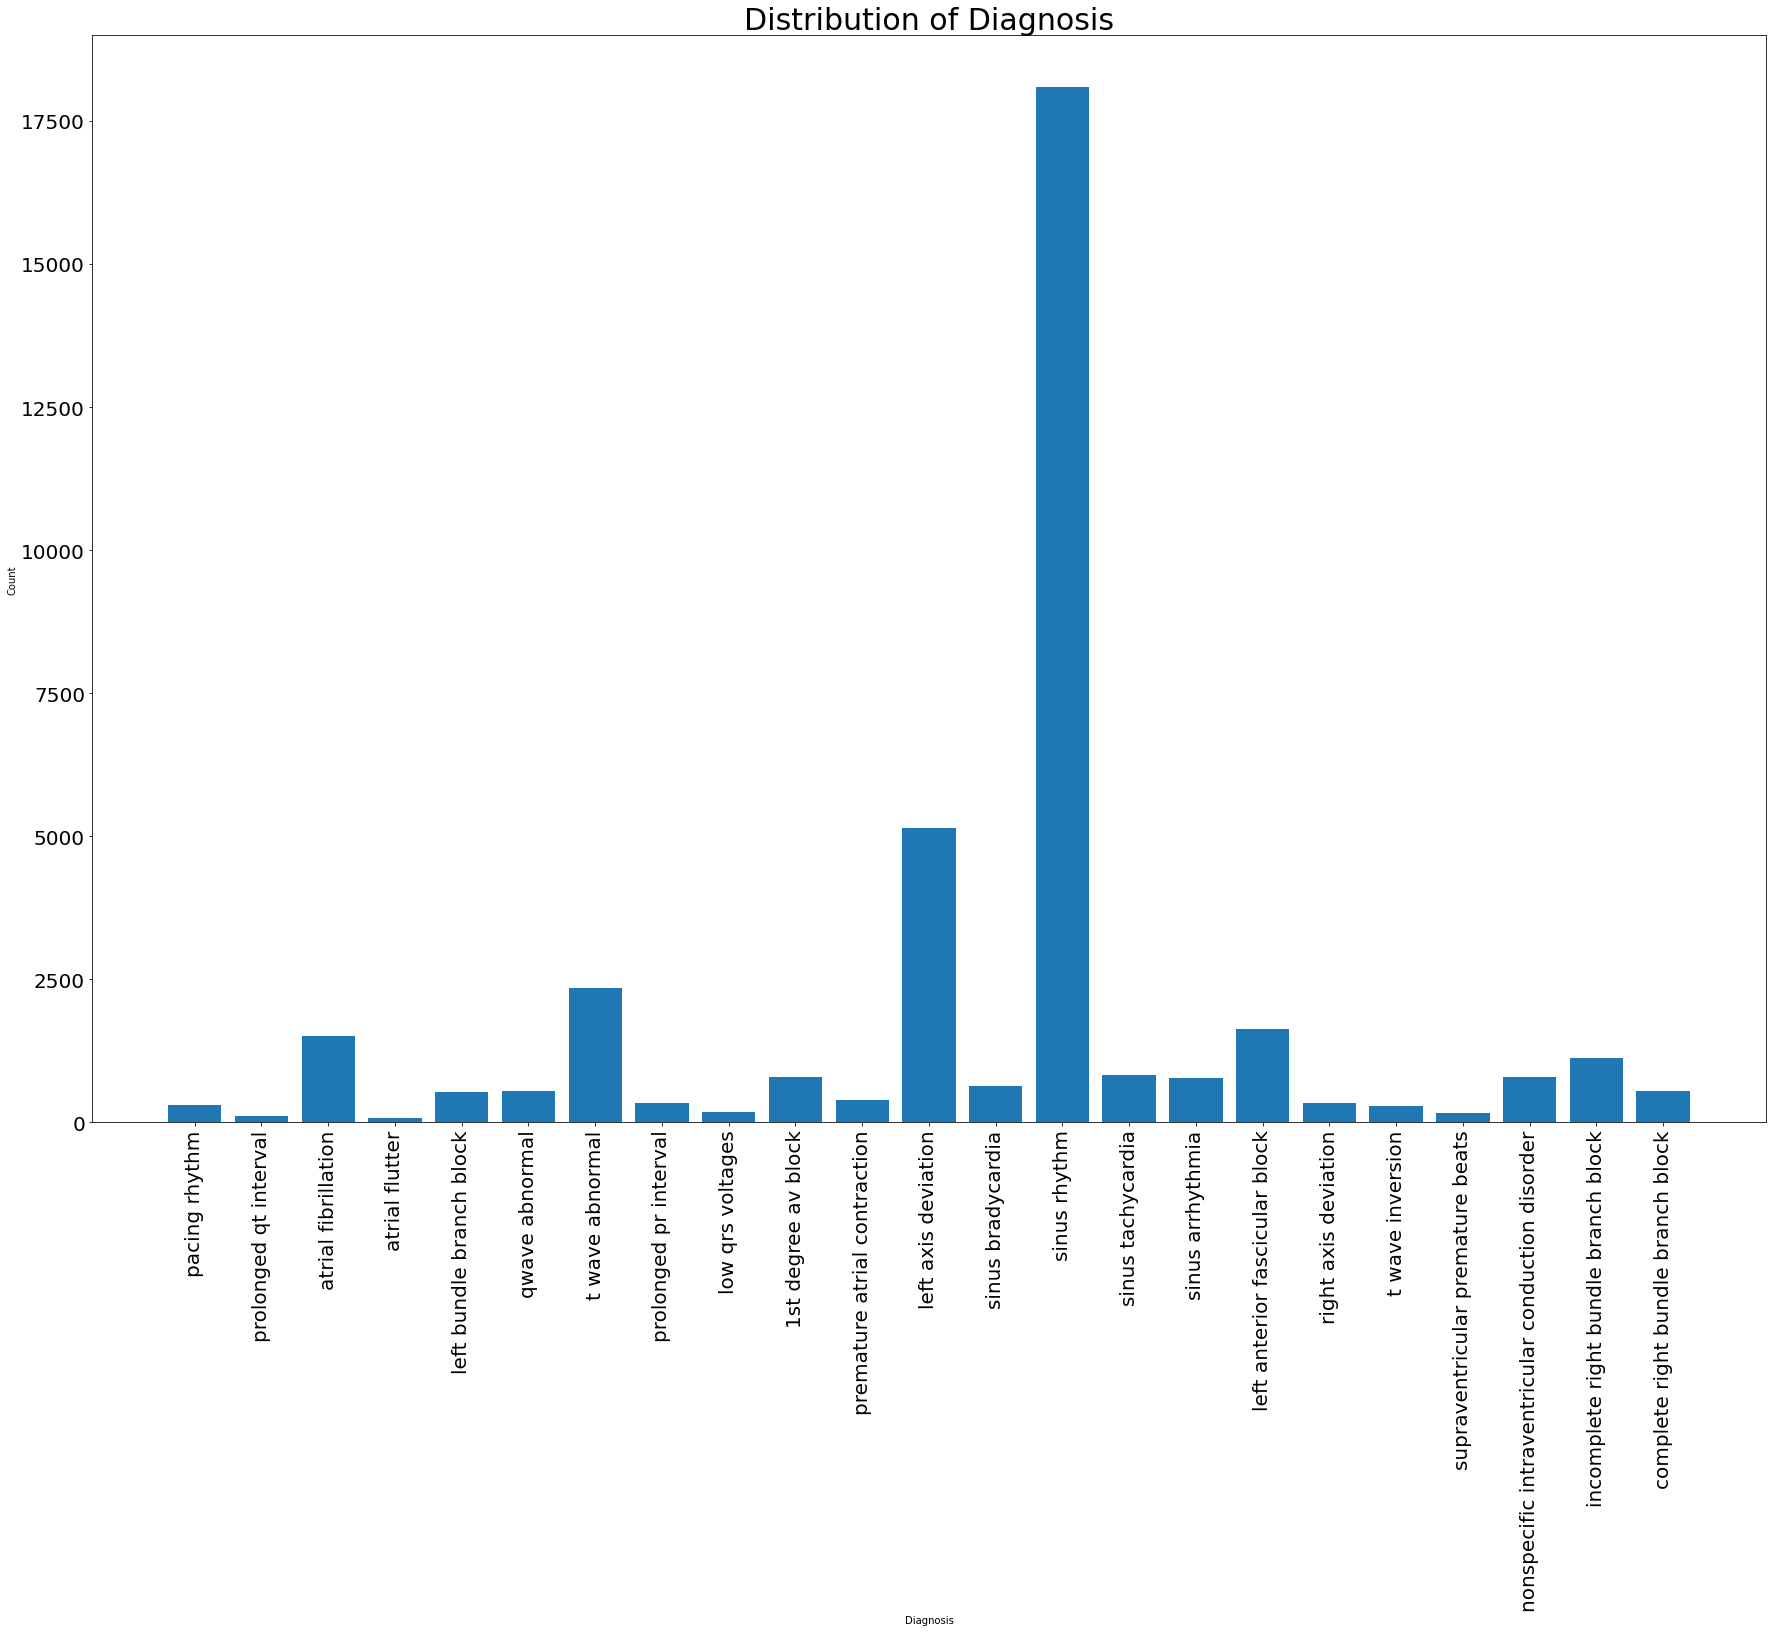

In [8]:
pc.plot_classes(snomed_classes, SNOMED_scored,y)

### Utility Functions

In [12]:
def shuffle_batch_generator(batch_size, gen_x,gen_y): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) 
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        yield batch_features, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = pc.load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new

### Conv1D-Stack

In [9]:
model_conv1d = Sequential()

model_conv1d.add(Conv1D(filters=6, kernel_size=3, padding='same', input_shape=(5000,12)))
model_conv1d.add(BatchNormalization())
model_conv1d.add(Activation('relu'))
model_conv1d.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

model_conv1d.add(Conv1D(filters=16, strides=1, kernel_size=5))
model_conv1d.add(BatchNormalization())
model_conv1d.add(Activation('relu'))
model_conv1d.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

model_conv1d.add(GlobalMaxPooling1D())

model_conv1d.add(Dense(64, activation='relu'))
model_conv1d.add(Dropout(0.25))
model_conv1d.add(Dense(32, activation='relu'))
model_conv1d.add(Dropout(0.25))
model_conv1d.add(Dense(27, activation='sigmoid'))

In [10]:
model_conv1d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5000, 6)           222       
_________________________________________________________________
batch_normalization (BatchNo (None, 5000, 6)           24        
_________________________________________________________________
activation (Activation)      (None, 5000, 6)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2500, 6)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2496, 16)          496       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2496, 16)          64        
_________________________________________________________________
activation_1 (Activation)    (None, 2496, 16)          0

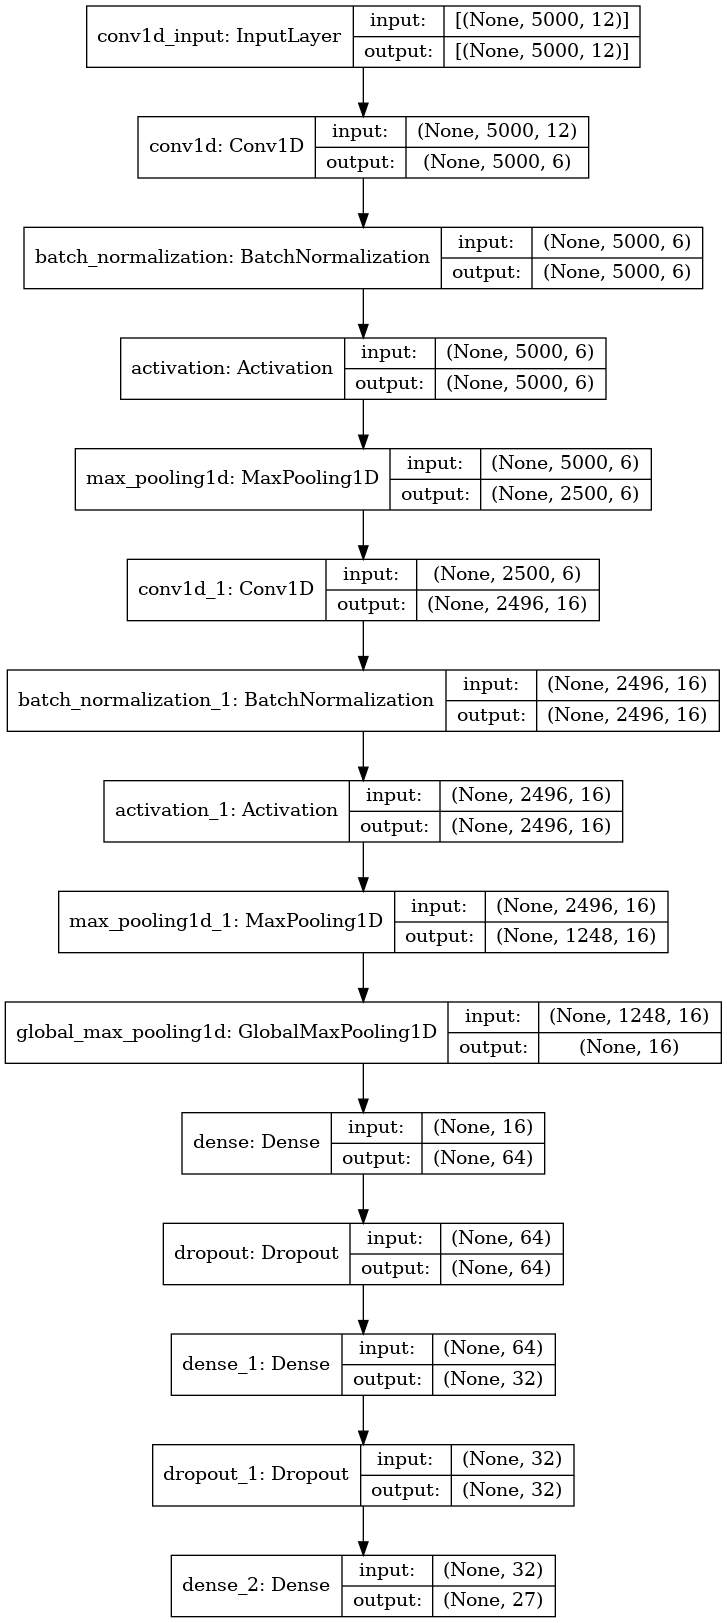

In [11]:
plot_model(model_conv1d, show_shapes=True)

In [13]:
batchsize = 10
model_conv1D.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), \
                                            gen_y=generate_y_shuffle(y)), epochs=10, \
                  steps_per_epoch=(len(order_array)/(batchsize*10)), \
                  validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), \
                  callbacks=[reduce_lr,early_stop])

NameError: name 'lenet_5_model' is not defined